In [1]:
import os
import numpy as np
import pandas as pd
import thunder as td
import matplotlib.pyplot as plt
import prairieModules
from glob import glob
import tifffile as tff
from skimage import measure
from matplotlib.path import Path
from skimage.io import imsave


In [2]:
imgPath = '/Users/zhengj10/Desktop/test_4-002/'


In [3]:
"""
xml file: time stamp of images
csv file: time stamp of voltage output
"""
imgFiles = glob(imgPath + '*.tif')
xmlFiles = glob(imgPath + '*.xml')
csvFiles = glob(imgPath + '*.csv')
imgFiles = sorted(imgFiles)
xmlFiles = sorted(xmlFiles)
csvFiles = sorted(csvFiles) # csvFile index is 0 for 300 ms protocol
print(imgFiles[0])
print(xmlFiles[0])
print(csvFiles[1])


/Users/zhengj10/Desktop/test_4-002/test_4-002_Cycle00001_Ch2_000001.ome.tif
/Users/zhengj10/Desktop/test_4-002/test_4-002.xml
/Users/zhengj10/Desktop/test_4-002/test_4-002_Cycle00001_VoltageRecording_001.csv


### Plot:
- voltage recording
- Photodiode recording
- voltage pulse peak (to confirm no_pulses is correct)

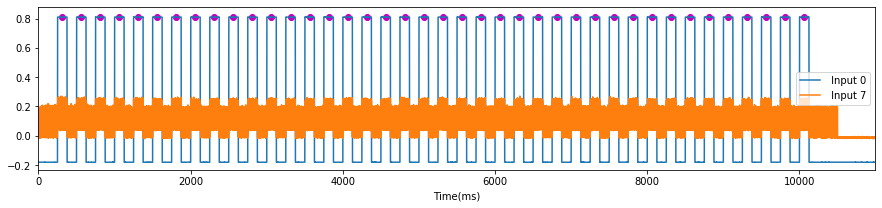

In [4]:
delay = 250
pulse_duration = 125
interval = 125
no_pulses = 40
cycle_duration = pulse_duration + interval
df = pd.read_csv(csvFiles[1])
# df.iloc[:2000].plot(kind='line', x = 'Time(ms)', y = [' Input 0'])
df.plot(kind='line', x = 'Time(ms)', y = [' Input 0', ' Input 7'], figsize=(15,3))
x = []
y = []
for i in range(no_pulses):
    x.append(delay + pulse_duration/2.0 + i*cycle_duration)
    y.append(0.81)
plt.scatter(x,y,color='m')    
# plt.xlim([0,10000])
# plt.xlim([9000,11000])
plt.show()


- images time stamp

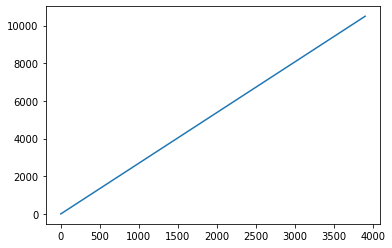

In [5]:
f_tstamp = prairieModules.getTime(xmlFiles[0])
f_tstamp = np.array(f_tstamp[0], dtype=np.float64)
f_tstamp = f_tstamp*1000
# f_tstamp = f_tstamp[:20000]
plt.plot(f_tstamp) # Straigt line confirms the time stamp intervals are consistant
plt.show()


In [6]:
f_tstamp[-1]


10498.654912

### Align images with voltage pulses

In [7]:
def align_FV(f_tstamp, delay = 250, pulse_duration = 125, interval = 125, no_pulses=40):
    indexes = []
    cycle_duration = pulse_duration + interval
    for pulse_no in range(no_pulses):
        pulse_end = delay + pulse_duration + pulse_no*cycle_duration
        idx = (np.abs(f_tstamp - pulse_end)).argmin()
        indexes.append(idx)
    return indexes


In [8]:
indexes = align_FV(f_tstamp, delay = 250, pulse_duration = 125, interval = 125, no_pulses=40)


### Find rois

- Plot mean image

In [9]:
from registration import CrossCorr

In [10]:
imgFile = tff.TiffFile(imgFiles[0])
imgFile = imgFile.asarray()


//anaconda3/lib/python3.7/site-packages/tifffile/tifffile.py:8929: RuntimeWarning: invalid value encountered in true_divide
  'ZDistance': values[:, 0] / values[:, 1],


In [11]:
reference = np.mean(imgFile, axis = 0)
reference.shape

(32, 256)

In [12]:
algorithm = CrossCorr()
model = algorithm.fit(imgFile, reference)
registered = model.transform(imgFile)
registered = registered.toarray()


In [13]:
imgFile = registered

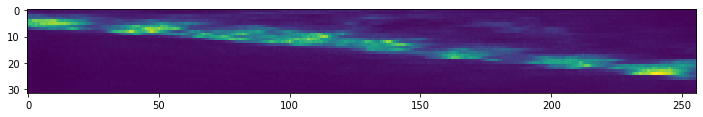

In [14]:
plt.figure(figsize=[12,3])
mean_image = np.mean(imgFile, axis = 0)
plt.imshow(mean_image)
plt.show()


- Creat a binary image with 0.6 x max value of mean image

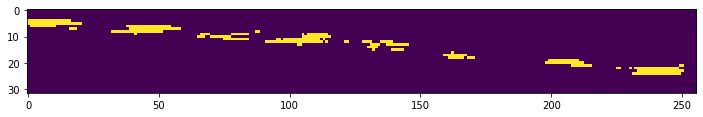

In [15]:
thre = 0.6*np.max(mean_image)
bin_image = mean_image>thre
bin_image = bin_image.astype(int)
plt.figure(figsize=[12,3])
plt.imshow(bin_image)
plt.show()


- Plot contours based on binary image

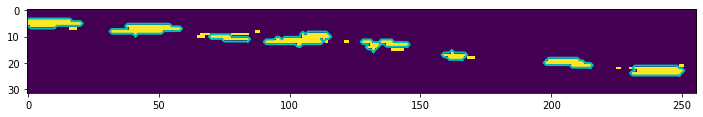

In [16]:
plt.figure(figsize=[12,3])
plt.imshow(bin_image)
contours = measure.find_contours(bin_image, 0.1)
thre = 17 # Exclude small ROIs
roi = 0
for contour in contours:
    if contour.shape[0]>thre:
        roi+=1
        plt.plot(contour[:,1], contour[:, 0], color = 'c', lw = 2)


- Show ROIs

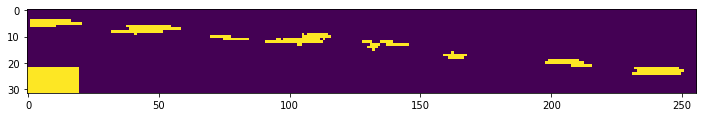

In [17]:
plt.figure(figsize=[12,3])
plt.imshow(np.zeros([32,256]))
coordinates = []
for r in range(bin_image.shape[0]):
    for c in range(bin_image.shape[1]):
        coordinates.append([r,c])
coordinates = np.array(coordinates)
rois = []
meanImg_b0 = []
rois = []
for contour in contours:
    if contour.shape[0]>thre:
        p = Path(contour)
        roi = p.contains_points(coordinates)
        roi = roi.reshape(32,256)
        f0 = np.sum(roi*mean_image)/np.sum(roi)
        rois.append(roi)
        meanImg_b0.append(roi*mean_image)


x = np.arange(0, 20)
y = np.arange(22, 32)
xv, yv = np.meshgrid(x, y)
mask = np.zeros(mean_image.shape)
mask[yv.flatten().astype(np.int), xv.flatten().astype(np.int)] = 1
rois.append(mask) # Add mask (fb)
meanImg_b0.append(rois[-1]*mean_image) # Add mask (fb)
rois_all = np.sum(rois,axis=0)      
        
plt.imshow(rois_all)
meanImg_b0 = np.sum(meanImg_b0,axis=0)
# plt.colorbar()
plt.show()


- Show ROIs with raw value

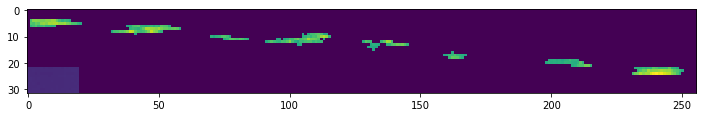

In [18]:
plt.figure(figsize=[12,3])
plt.imshow(meanImg_b0)
# plt.colorbar()
plt.show()


### Plot:
- dFF traces

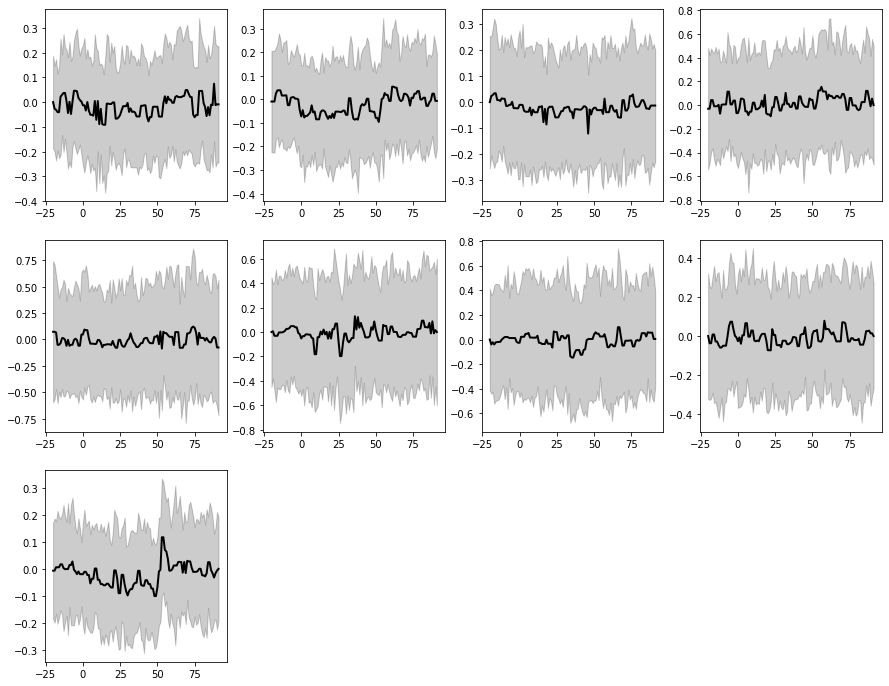

In [32]:
import scipy.signal as ss

bl_frames = 20
frames_interval = f_tstamp[1]-f_tstamp[0]
total_frames = int((pulse_duration + interval)/frames_interval) + bl_frames

fig = plt.figure(figsize=(15,12))
dff_all = []
raw_all = []
for roi_no in range(len(rois)-1): # To exclude fb
    data_raw = []
    data_dff = []
    for i in range(len(indexes)):
        f0 = (np.sum(rois[roi_no]*np.mean(imgFile[indexes[i]-20:indexes[i],:,:],axis=0)))/np.sum(rois[roi_no])
        fb = (np.sum(rois[-1]*np.mean(imgFile[indexes[i]-20:indexes[i],:,:],axis=0)))/np.sum(rois[-1])
        seg_raw = []
        seg_dff = []
        for frame in range(total_frames):
            f = np.sum(rois[roi_no]*imgFile[indexes[i]-20+frame,:,:])/np.sum(rois[roi_no])
            dff = (f-f0)/(f0-fb)
            seg_raw.append(f)
            seg_dff.append(dff)
        data_raw.append(seg_raw)
        data_dff.append(seg_dff)
    dff_mean = np.mean(data_dff, axis=0)
    dff_std = np.std(data_dff, axis=0)
    raw_mean = np.mean(data_raw, axis=0)
    raw_std = np.std(data_raw, axis=0)
    x = np.arange(total_frames)-bl_frames
    ax = fig.add_subplot(len(rois)/4+1,4,roi_no+1)
    dff_mean = ss.medfilt(dff_mean, kernel_size=3)
    ax.plot(x, dff_mean, color = 'k', lw=2)
    ax.fill_between(x, dff_mean - dff_std, dff_mean + dff_std, color='k', alpha=0.2)
#     ax.plot(x, raw_mean, color = 'k', lw=2)
#     ax.fill_between(x, raw_mean - raw_std, raw_mean + raw_std, color='k', alpha=0.2)
    dff_all.append(dff_mean)
    raw_all.append(raw_mean)
plt.show()


- All ROIs average

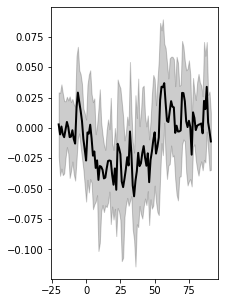

In [33]:
dff_all_mean = np.mean(dff_all,axis=0)
# dff_all_mean = ss.medfilt(dff_all_mean, kernel_size=7) # Median filter applied to dff_all_mean
dff_all_std = np.std(dff_all,axis=0)
fig,(ax) = plt.subplots(1,1,figsize=[3,5])
x = np.arange(total_frames)-bl_frames
ax.plot(x, dff_all_mean, color = 'k', lw=2)
ax.fill_between(x, dff_all_mean - dff_all_std, dff_all_mean + dff_all_std, color='k', alpha=0.2)
plt.show()
